## Regression Problem: House Prices Prediction
In this exercise, we will solve a regression problem with a neural network.

**Objective:** The goal is to predict the house selling prices .

**Dataset:**  A csv file with 1460 samples is provided (on the course webpage). Each example contains four input features. We will use 1000 examples as training set, 200 as validation set and the rest as test set.   
   * **Feature names**: OverallQual, YearBuilt, TotalBsmtSF, GrLivArea
   * **Target**: SalePrice

**NB:** new required libraries: `pandas`, `seaborn`.

In [519]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)
%matplotlib inline

cuda


In [452]:
# Load data:
df = pd.read_csv("house_prices.csv")

In [453]:
df.head(3)

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,SalePrice
0,7,2003,856,1710,208500
1,6,1976,1262,1262,181500
2,7,2001,920,1786,223500


In [454]:
df.info() # get more information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   OverallQual  1460 non-null   int64
 1   YearBuilt    1460 non-null   int64
 2   TotalBsmtSF  1460 non-null   int64
 3   GrLivArea    1460 non-null   int64
 4   SalePrice    1460 non-null   int64
dtypes: int64(5)
memory usage: 57.2 KB


### Data Analysis
Before training, we need first to analyze the dataset, to know its properties better.

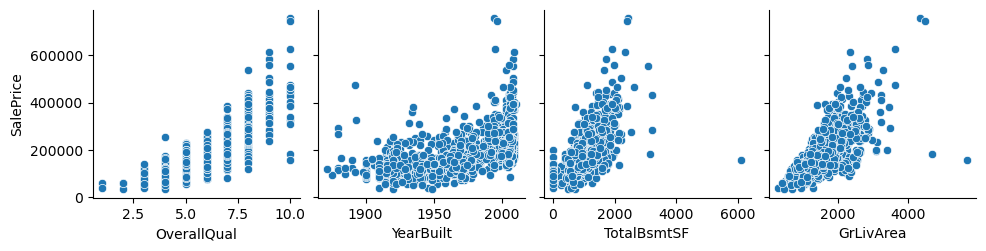

In [455]:
sns.pairplot(df, x_vars=['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea'], 
             y_vars=['SalePrice'])

### House prices prediction

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll start with and improve during this exercise.

Look at the code and run it to see its structure, then follow the questions below to iteratively improve the model.

In [456]:
X = df[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea']] # get the four features from the dataframe
y = df['SalePrice'] # get the target values

In [498]:
X_train = X.iloc[:1000]
y_train = y.iloc[:1000]

X_val = X.iloc[1000:1200]
y_val = y.iloc[1000:1200]

X_test = X.iloc[1200:]
y_test = y.iloc[1200:]

### Normalize data

Note that you can transform you data back in the original space via the command <code>scaler.inverse_transform()</code>.

In [635]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_x = scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

scaler_y = MinMaxScaler()
scaler_y = scaler_y.fit(np.array(y_train).reshape(-1,1))
y_train = scaler_y.transform(np.array(y_train).reshape(-1,1)).squeeze()

y_val = scaler_y.transform(np.array(y_val).reshape(-1,1)).squeeze()
y_test = scaler_y.transform(np.array(y_test).reshape(-1,1)).squeeze()

In [579]:
# Construct a model with one layer
class Model(nn.Module):
    
    def __init__(self, nb_hidden_layer = 2, activation = "ReLU", nb_neuron = 3):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(4, nb_neuron)
        if activation == "ReLU":
            self.activation = nn.ReLU()
        elif activation == "Tanh":
            self.activation = nn.Tanh()
        elif activation == "Sigmoid":
            self.activation = nn.Sigmoid()
        else:
            raise ValueError(f"No activation function is available for {activation}.")

        list_layer = [self.l1, self.activation]
        for i in range(nb_hidden_layer):
            list_layer += [nn.Linear(nb_neuron, nb_neuron, bias=True)]
            list_layer += [self.activation]
        list_layer += [nn.Linear(nb_neuron, 1, bias=True)]
        self.layer=nn.Sequential(*list_layer)

    def init_layers(self):
        for param in self.parameters():
            nn.init.normal_(param, mean=0, std=.1)
    def forward(self, x):
        return self.layer(x)

In [580]:
train_set = TensorDataset(torch.from_numpy(np.array(X_train)).float(),
                          torch.from_numpy(np.array(y_train)).float()) # create the dataset.

train_loader = DataLoader(train_set, shuffle=True, batch_size=10)

In [581]:
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    training_loss=[]
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X, y) in dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device).squeeze()
            y_pre = model(X).view(-1)
            loss = criterion(y_pre, y)
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)
        training_loss += [epoch_average_loss]
        if ((epoch)%1 == 0):
                print('Epoch [{}/{}], Loss_error: {:.4f}'
                      .format(epoch, num_epochs,  epoch_average_loss))
    return training_loss

#### Evaluate the Model on the validation set

In [478]:
def test(model, X_val):
    # Calculate mean squared error on validation set
    model.eval()
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(X_val)).float().to(device)).view(-1)
    error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float().to(device)).item()
    print('The loss on validation set is:', error)

In [512]:
# Define hyper-parameters:
model = Model()
model=model.to(device)
model.init_layers()

# Choose the hyperparameters for training:
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

Epoch [0/10], Loss_error: 0.0182
Epoch [1/10], Loss_error: 0.0125
Epoch [2/10], Loss_error: 0.0125
Epoch [3/10], Loss_error: 0.0124
Epoch [4/10], Loss_error: 0.0124
Epoch [5/10], Loss_error: 0.0124
Epoch [6/10], Loss_error: 0.0124
Epoch [7/10], Loss_error: 0.0124
Epoch [8/10], Loss_error: 0.0124
Epoch [9/10], Loss_error: 0.0124
The loss on validation set is: 0.013889018446207047


Text(0.5, 1.0, 'Training loss')

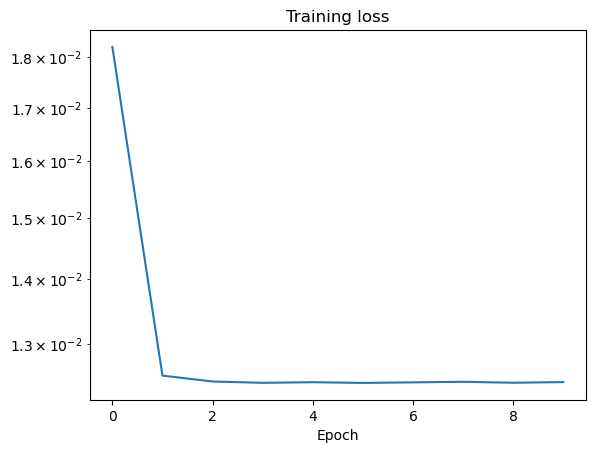

In [513]:
training_loss = train(num_epochs, batch_size, criterion, optimizer, model, train_set)
test(model=model, X_val=X_val)
plt.plot(training_loss)
plt.yscale("log")
plt.xlabel("Epoch")
plt.title("Training loss")

### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons in each layer (5, 10, 20, more ?)

### Testing # of hidden layers and # of neurons per hidden layer

Epoch [0/10], Loss_error: 0.0399
Epoch [1/10], Loss_error: 0.0305
Epoch [2/10], Loss_error: 0.0243
Epoch [3/10], Loss_error: 0.0202
Epoch [4/10], Loss_error: 0.0176
Epoch [5/10], Loss_error: 0.0158
Epoch [6/10], Loss_error: 0.0147
Epoch [7/10], Loss_error: 0.0139
Epoch [8/10], Loss_error: 0.0134
Epoch [9/10], Loss_error: 0.0131
The loss on validation set is: 0.014102214016020298
Epoch [0/10], Loss_error: 0.0399
Epoch [1/10], Loss_error: 0.0303
Epoch [2/10], Loss_error: 0.0240
Epoch [3/10], Loss_error: 0.0200
Epoch [4/10], Loss_error: 0.0174
Epoch [5/10], Loss_error: 0.0156
Epoch [6/10], Loss_error: 0.0145
Epoch [7/10], Loss_error: 0.0138
Epoch [8/10], Loss_error: 0.0133
Epoch [9/10], Loss_error: 0.0130
The loss on validation set is: 0.014108460396528244
Epoch [0/10], Loss_error: 0.1298
Epoch [1/10], Loss_error: 0.0893
Epoch [2/10], Loss_error: 0.0627
Epoch [3/10], Loss_error: 0.0453
Epoch [4/10], Loss_error: 0.0338
Epoch [5/10], Loss_error: 0.0264
Epoch [6/10], Loss_error: 0.0215
Epoch

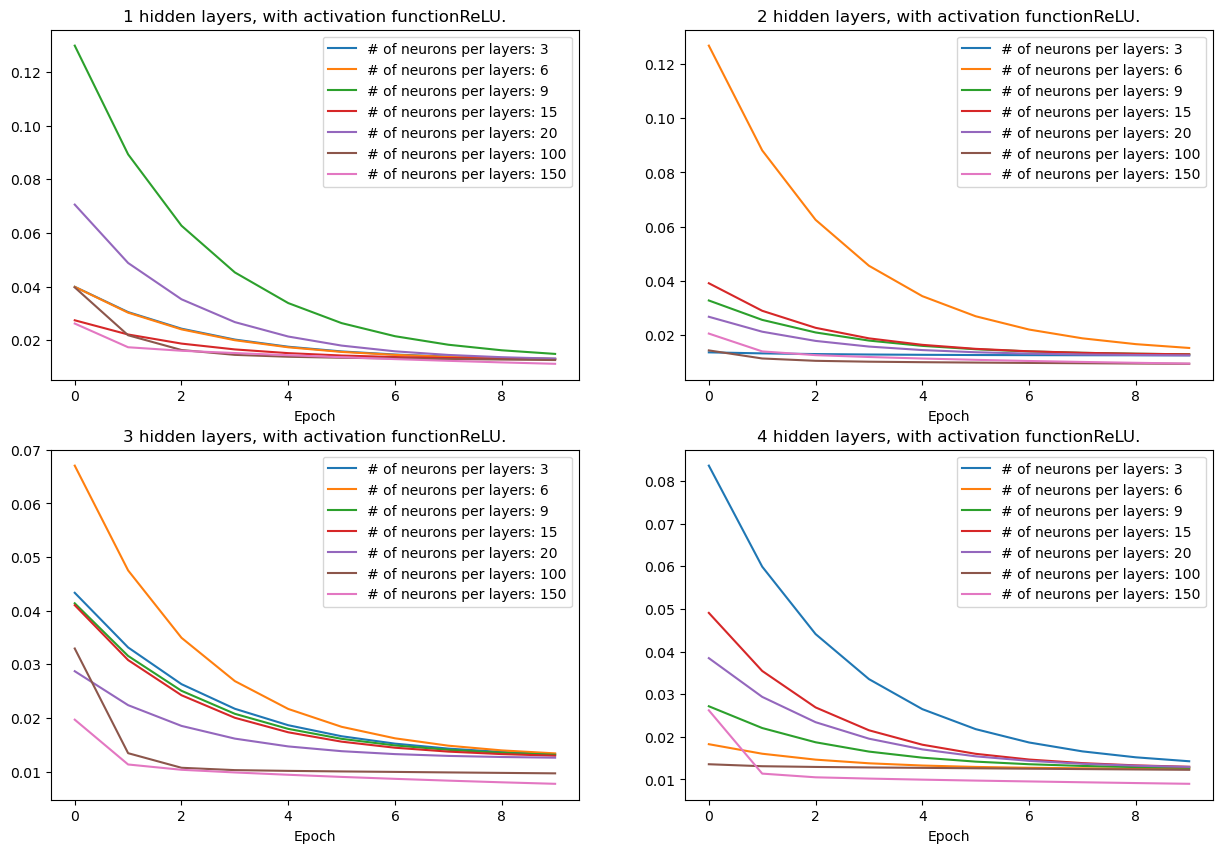

In [ ]:
hidden_layers=[1, 2, 3, 4]
nb_neuron=[3, 6, 9, 15, 20, 100, 150]
fig, ax = plt.subplots(2,2, figsize=(15,10))
start=time.time()
for i, h in enumerate(hidden_layers):
    for n in nb_neuron:
        # Define hyper-parameters:
        activation=f"ReLU"
        model = Model(nb_hidden_layer=h, activation=activation, nb_neuron=n)
        model.init_layers()
        model=model.to(device)
        # Choose the hyperparameters for training: 
        num_epochs = 10
        batch_size = 10

        # Training criterion. This one is a mean squared error (MSE) loss between the output
        # of the network and the target label
        criterion = nn.MSELoss()

        # Use SGD optimizer with a learning rate of 0.01
        # It is initialized in our model
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
        training_loss=train(num_epochs=num_epochs, batch_size=batch_size, criterion=criterion, optimizer=optimizer, model=model, dataset=train_set)
        test(model, X_val)
        ax[i//2, i%2].plot(training_loss, label=f"# of neurons per layers: {n}")
        ax[i//2, i%2].set_title(f"{h} hidden layers, with activation function " + activation + f".")
        ax[i//2, i%2].legend()
        ax[i//2, i%2].set_xlabel("Epoch")
print("The simulation lasted ", time.time() - start)

Epoch [0/10], Loss_error: 0.0372
Epoch [1/10], Loss_error: 0.0246
Epoch [2/10], Loss_error: 0.0184
Epoch [3/10], Loss_error: 0.0154
Epoch [4/10], Loss_error: 0.0139
Epoch [5/10], Loss_error: 0.0131
Epoch [6/10], Loss_error: 0.0128
Epoch [7/10], Loss_error: 0.0126
Epoch [8/10], Loss_error: 0.0125
Epoch [9/10], Loss_error: 0.0125
The loss on validation set is: 0.013847777619957924
Epoch [0/10], Loss_error: 0.0453
Epoch [1/10], Loss_error: 0.0251
Epoch [2/10], Loss_error: 0.0174
Epoch [3/10], Loss_error: 0.0143
Epoch [4/10], Loss_error: 0.0132
Epoch [5/10], Loss_error: 0.0127
Epoch [6/10], Loss_error: 0.0125
Epoch [7/10], Loss_error: 0.0125
Epoch [8/10], Loss_error: 0.0124
Epoch [9/10], Loss_error: 0.0124
The loss on validation set is: 0.013865651562809944
Epoch [0/10], Loss_error: 0.0213
Epoch [1/10], Loss_error: 0.0147
Epoch [2/10], Loss_error: 0.0130
Epoch [3/10], Loss_error: 0.0126
Epoch [4/10], Loss_error: 0.0125
Epoch [5/10], Loss_error: 0.0124
Epoch [6/10], Loss_error: 0.0124
Epoch

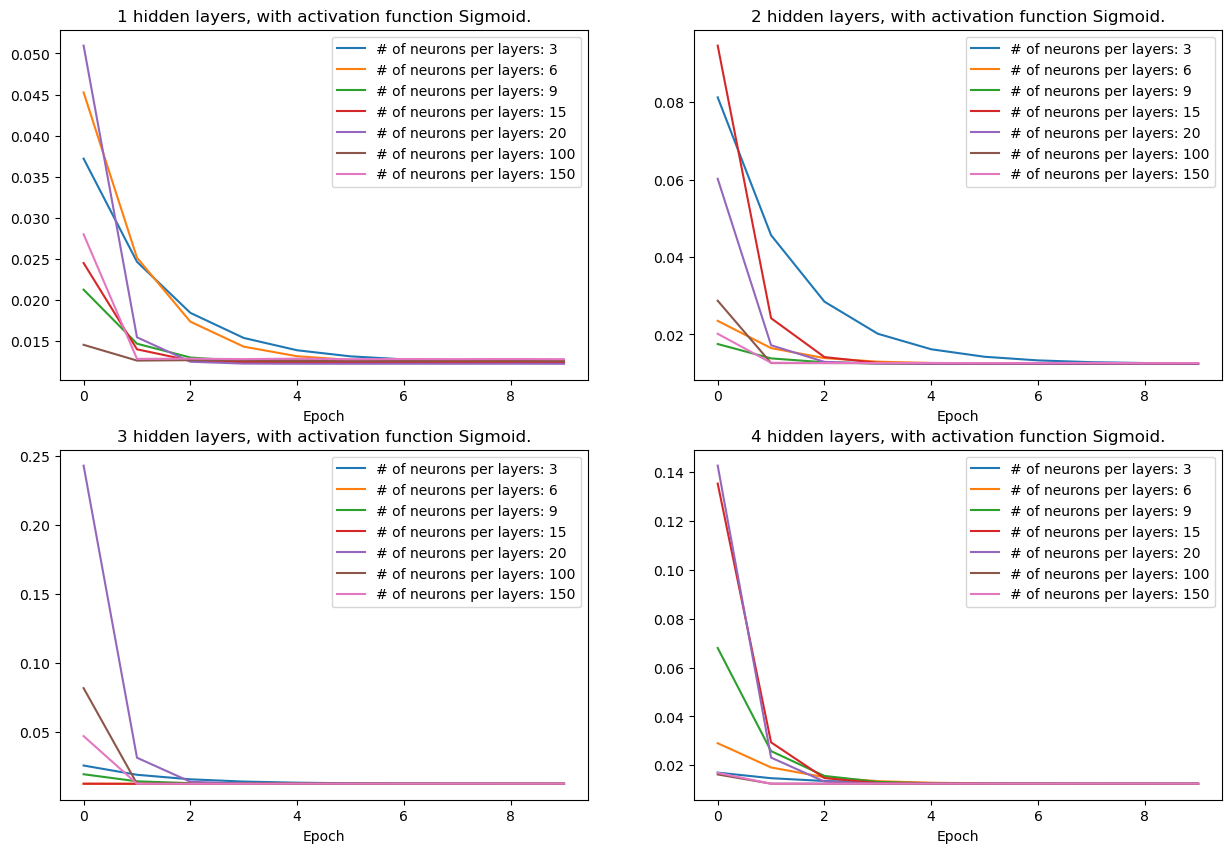

In [540]:
hidden_layers=[1, 2, 3, 4]
nb_neuron=[3, 6, 9, 15, 20, 100, 150]
fig, ax = plt.subplots(2,2, figsize=(15,10))
start=time.time()
for i, h in enumerate(hidden_layers):
    for n in nb_neuron:
        # Define hyper-parameters:
        activation=f"Sigmoid"
        model = Model(nb_hidden_layer=h, activation=activation, nb_neuron=n)
        model.init_layers()
        model=model.to(device)
        # Choose the hyperparameters for training: 
        num_epochs = 10
        batch_size = 10

        # Training criterion. This one is a mean squared error (MSE) loss between the output
        # of the network and the target label
        criterion = nn.MSELoss()

        # Use SGD optimizer with a learning rate of 0.01
        # It is initialized in our model
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
        training_loss=train(num_epochs=num_epochs, batch_size=batch_size, criterion=criterion, optimizer=optimizer, model=model, dataset=train_set)
        test(model, X_val)
        ax[i//2, i%2].plot(training_loss, label=f"# of neurons per layers: {n}")
        ax[i//2, i%2].set_title(f"{h} hidden layers, with activation function " + activation + f".")
        ax[i//2, i%2].legend()
        ax[i//2, i%2].set_xlabel("Epoch")
print("The simulation lasted ", time.time() - start)

Epoch [0/10], Loss_error: 0.0412
Epoch [1/10], Loss_error: 0.0310
Epoch [2/10], Loss_error: 0.0244
Epoch [3/10], Loss_error: 0.0202
Epoch [4/10], Loss_error: 0.0174
Epoch [5/10], Loss_error: 0.0156
Epoch [6/10], Loss_error: 0.0145
Epoch [7/10], Loss_error: 0.0138
Epoch [8/10], Loss_error: 0.0133
Epoch [9/10], Loss_error: 0.0130
The loss on validation set is: 0.014049820601940155
Epoch [0/10], Loss_error: 0.0423
Epoch [1/10], Loss_error: 0.0319
Epoch [2/10], Loss_error: 0.0251
Epoch [3/10], Loss_error: 0.0207
Epoch [4/10], Loss_error: 0.0177
Epoch [5/10], Loss_error: 0.0159
Epoch [6/10], Loss_error: 0.0146
Epoch [7/10], Loss_error: 0.0138
Epoch [8/10], Loss_error: 0.0133
Epoch [9/10], Loss_error: 0.0130
The loss on validation set is: 0.01399276964366436
Epoch [0/10], Loss_error: 0.0598
Epoch [1/10], Loss_error: 0.0411
Epoch [2/10], Loss_error: 0.0299
Epoch [3/10], Loss_error: 0.0230
Epoch [4/10], Loss_error: 0.0188
Epoch [5/10], Loss_error: 0.0163
Epoch [6/10], Loss_error: 0.0147
Epoch 

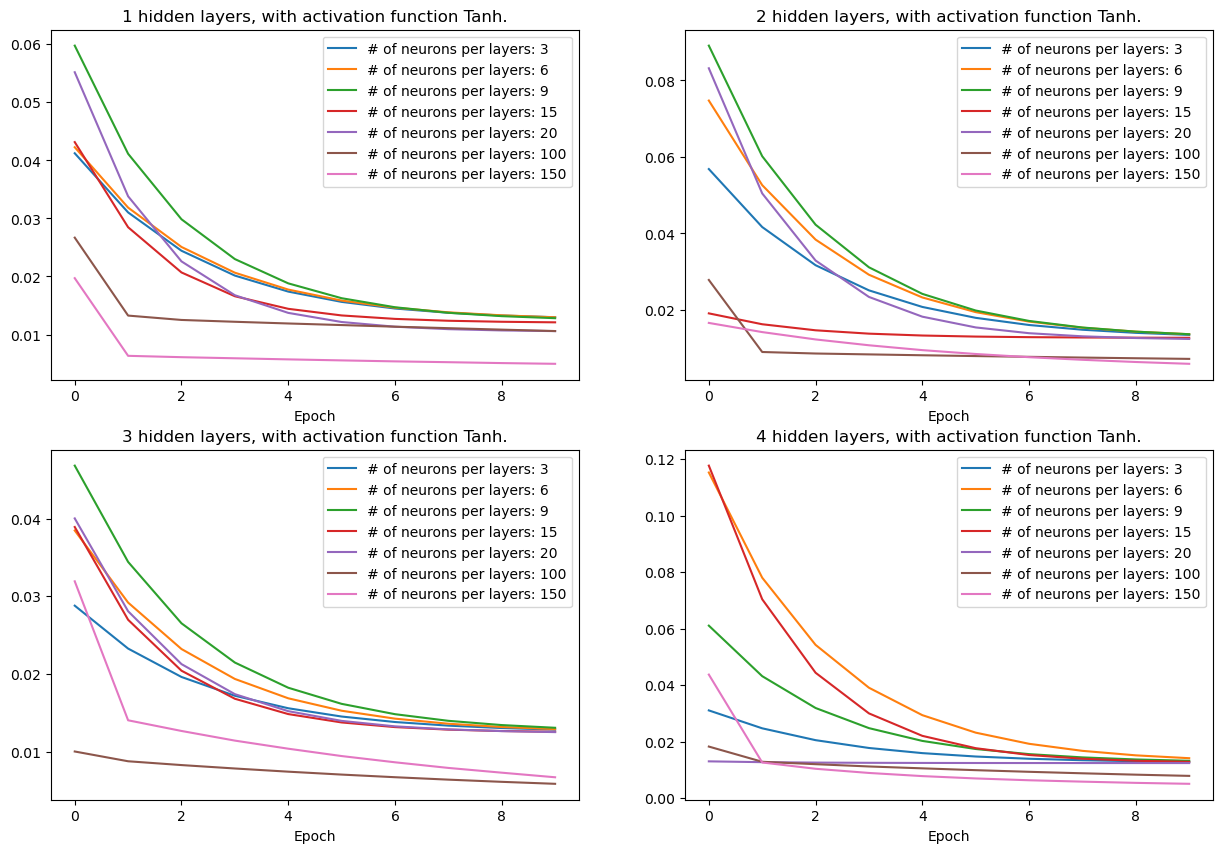

In [541]:
hidden_layers=[1, 2, 3, 4]
nb_neuron=[3, 6, 9, 15, 20, 100, 150]
fig, ax = plt.subplots(2,2, figsize=(15,10))
start=time.time()
for i, h in enumerate(hidden_layers):
    for n in nb_neuron:
        # Define hyper-parameters:
        activation=f"Tanh"
        model = Model(nb_hidden_layer=h, activation=activation, nb_neuron=n)
        model.init_layers()
        model=model.to(device)
        # Choose the hyperparameters for training: 
        num_epochs = 10
        batch_size = 10

        # Training criterion. This one is a mean squared error (MSE) loss between the output
        # of the network and the target label
        criterion = nn.MSELoss()

        # Use SGD optimizer with a learning rate of 0.01
        # It is initialized in our model
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
        training_loss=train(num_epochs=num_epochs, batch_size=batch_size, criterion=criterion, optimizer=optimizer, model=model, dataset=train_set)
        test(model, X_val)
        ax[i//2, i%2].plot(training_loss, label=f"# of neurons per layers: {n}")
        ax[i//2, i%2].set_title(f"{h} hidden layers, with activation function " + activation + f".")
        ax[i//2, i%2].legend()
        ax[i//2, i%2].set_xlabel("Epoch")
print("The simulation lasted ", time.time() - start)

### Exercise 2: Impact of the optimizer

Retrain the model with different parameters of the optimizer; you can change then in the cell initializing the optimizer, after the definition of your model.

* Use different batch sizes, from 10 to 400 e.g.
* Try different values of the learning rate (between 0.001 and 10), and see how they impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

### Impact of batch size, learning rate & activation function

Concerning the architecture, I fix 4 hidden layers with 150 neurons each.

Epoch [0/10], Loss_error: 0.0126
Epoch [1/10], Loss_error: 0.0117
Epoch [2/10], Loss_error: 0.0112
Epoch [3/10], Loss_error: 0.0107
Epoch [4/10], Loss_error: 0.0103
Epoch [5/10], Loss_error: 0.0101
Epoch [6/10], Loss_error: 0.0098
Epoch [7/10], Loss_error: 0.0095
Epoch [8/10], Loss_error: 0.0093
Epoch [9/10], Loss_error: 0.0091
The loss on validation set is: 0.01057477481663227
Epoch [0/10], Loss_error: 0.0097
Epoch [1/10], Loss_error: 0.0065
Epoch [2/10], Loss_error: 0.0054
Epoch [3/10], Loss_error: 0.0045
Epoch [4/10], Loss_error: 0.0040
Epoch [5/10], Loss_error: 0.0037
Epoch [6/10], Loss_error: 0.0034
Epoch [7/10], Loss_error: 0.0032
Epoch [8/10], Loss_error: 0.0030
Epoch [9/10], Loss_error: 0.0029
The loss on validation set is: 0.0038079950027167797
Epoch [0/10], Loss_error: 0.0110
Epoch [1/10], Loss_error: 0.0060
Epoch [2/10], Loss_error: 0.0042
Epoch [3/10], Loss_error: 0.0034
Epoch [4/10], Loss_error: 0.0034
Epoch [5/10], Loss_error: 0.0032
Epoch [6/10], Loss_error: 0.0033
Epoch

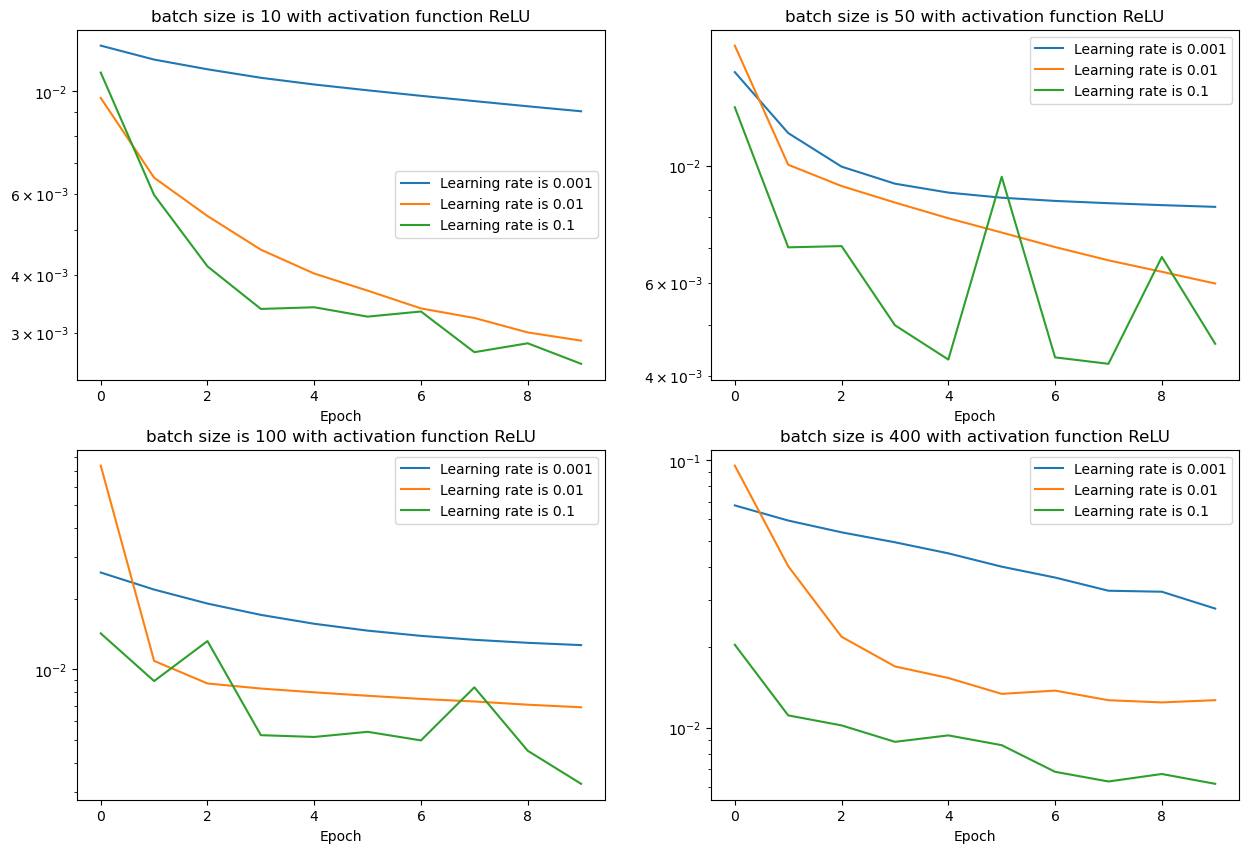

In [653]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
batch_size = [ 10, 50, 100, 400]
learning_rate=[1e-3, 1e-2, 1e-1]
start=time.time()
for i, b in enumerate(batch_size):
    for lr in learning_rate:
        # Define hyper-parameters:
        activation="ReLU"
        model = Model(nb_hidden_layer=4, activation=activation, nb_neuron=150)
        model.init_layers()
        model=model.to(device)
        # Choose the hyperparameters for training:
        num_epochs = 10
        batch_size = b

        # Training criterion. This one is a mean squared error (MSE) loss between the output
        # of the network and the target label
        criterion = nn.MSELoss()

        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        training_loss=train(num_epochs=num_epochs, batch_size=batch_size, criterion=criterion, optimizer=optimizer, model=model, dataset=train_set)
        test(model, X_val)
        ax[i//2,i%2].plot(training_loss, label=f"Learning rate is {lr}")
        ax[i//2,i%2].set_title(f"batch size is {batch_size} with activation function " + activation)
        ax[i//2,i%2].legend()
        ax[i//2,i%2].set_yscale("log")
        ax[i//2,i%2].set_xlabel("Epoch")
    print("Time of simulation {} seconds".format(time.time() - start))

Epoch [0/10], Loss_error: 0.0152
Epoch [1/10], Loss_error: 0.0120
Epoch [2/10], Loss_error: 0.0098
Epoch [3/10], Loss_error: 0.0082
Epoch [4/10], Loss_error: 0.0070
Epoch [5/10], Loss_error: 0.0060
Epoch [6/10], Loss_error: 0.0053
Epoch [7/10], Loss_error: 0.0047
Epoch [8/10], Loss_error: 0.0043
Epoch [9/10], Loss_error: 0.0040
The loss on validation set is: 0.004645873326808214
Epoch [0/10], Loss_error: 0.0117
Epoch [1/10], Loss_error: 0.0038
Epoch [2/10], Loss_error: 0.0035
Epoch [3/10], Loss_error: 0.0034
Epoch [4/10], Loss_error: 0.0036
Epoch [5/10], Loss_error: 0.0033
Epoch [6/10], Loss_error: 0.0032
Epoch [7/10], Loss_error: 0.0036
Epoch [8/10], Loss_error: 0.0038
Epoch [9/10], Loss_error: 0.0034
The loss on validation set is: 0.003319529816508293
Epoch [0/10], Loss_error: nan
Epoch [1/10], Loss_error: nan
Epoch [2/10], Loss_error: nan
Epoch [3/10], Loss_error: nan
Epoch [4/10], Loss_error: nan
Epoch [5/10], Loss_error: nan
Epoch [6/10], Loss_error: nan
Epoch [7/10], Loss_error: 

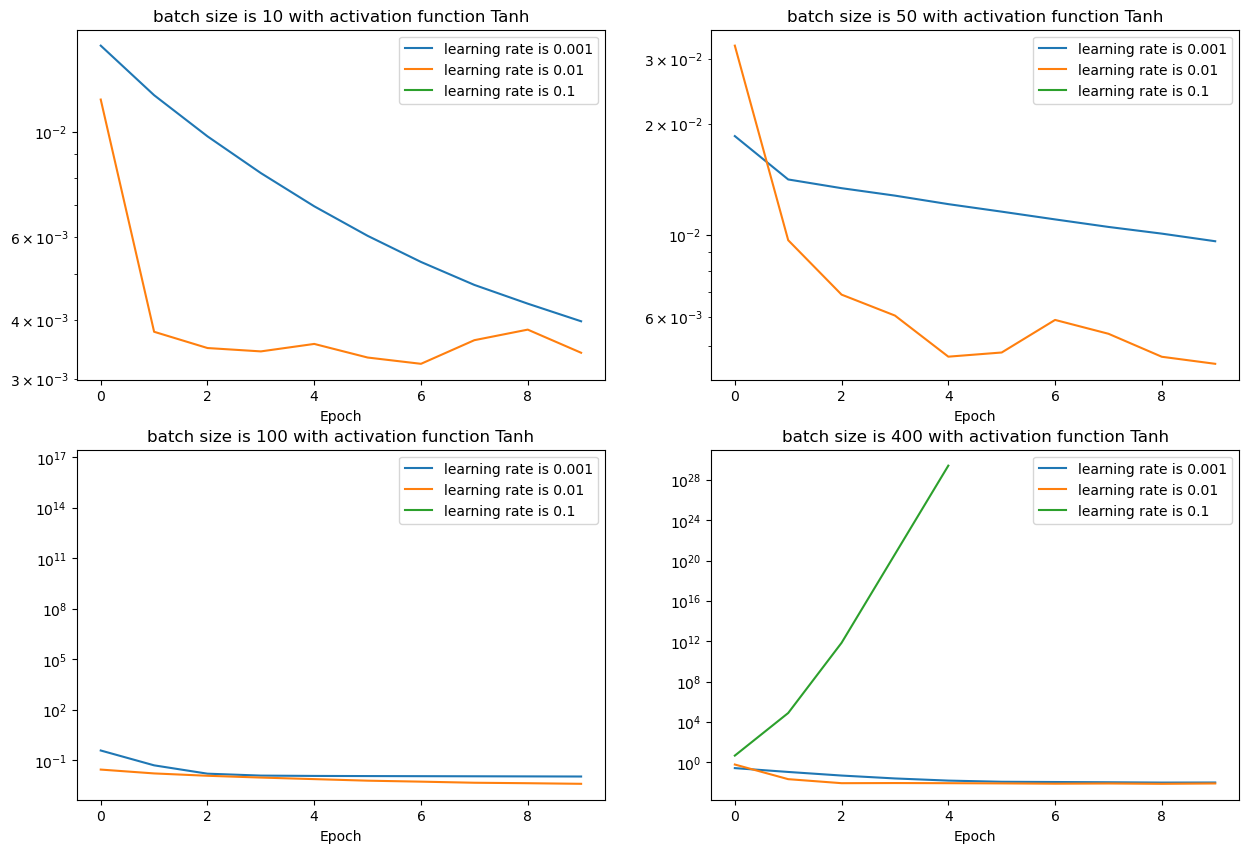

In [649]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
batch_size = [ 10, 50, 100, 400]
learning_rate=[1e-3, 1e-2, 1e-1]
start=time.time()
for i, b in enumerate(batch_size):
    for lr in learning_rate:
        # Define hyper-parameters:
        activation="Tanh"
        model = Model(nb_hidden_layer=4, activation=activation, nb_neuron=150)
        model.init_layers()
        model=model.to(device)
        # Choose the hyperparameters for training:
        num_epochs = 10
        batch_size = b

        # Training criterion. This one is a mean squared error (MSE) loss between the output
        # of the network and the target label
        criterion = nn.MSELoss()

        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        training_loss=train(num_epochs=num_epochs, batch_size=batch_size, criterion=criterion, optimizer=optimizer, model=model, dataset=train_set)
        test(model, X_val)
        ax[i//2,i%2].plot(training_loss, label=f"learning rate is {lr}")
        ax[i//2,i%2].set_title(f"batch size is {batch_size} with activation function " + activation)
        ax[i//2,i%2].legend()
        ax[i//2,i%2].set_yscale('log')
        ax[i//2,i%2].set_xlabel("Epoch")
    print("Time of simulation {} seconds".format(time.time() - start))

Epoch [0/10], Loss_error: 0.0127
Epoch [1/10], Loss_error: 0.0125
Epoch [2/10], Loss_error: 0.0125
Epoch [3/10], Loss_error: 0.0125
Epoch [4/10], Loss_error: 0.0125
Epoch [5/10], Loss_error: 0.0125
Epoch [6/10], Loss_error: 0.0125
Epoch [7/10], Loss_error: 0.0125
Epoch [8/10], Loss_error: 0.0124
Epoch [9/10], Loss_error: 0.0125
The loss on validation set is: 0.013888916932046413
Epoch [0/10], Loss_error: 0.0144
Epoch [1/10], Loss_error: 0.0138
Epoch [2/10], Loss_error: 0.0136
Epoch [3/10], Loss_error: 0.0137
Epoch [4/10], Loss_error: 0.0131
Epoch [5/10], Loss_error: 0.0132
Epoch [6/10], Loss_error: 0.0139
Epoch [7/10], Loss_error: 0.0131
Epoch [8/10], Loss_error: 0.0135
Epoch [9/10], Loss_error: 0.0135
The loss on validation set is: 0.014192759990692139
Epoch [0/10], Loss_error: 3.5816
Epoch [1/10], Loss_error: 0.0126
Epoch [2/10], Loss_error: 0.0126
Epoch [3/10], Loss_error: 0.0126
Epoch [4/10], Loss_error: 0.0126
Epoch [5/10], Loss_error: 0.0126
Epoch [6/10], Loss_error: 0.0127
Epoch

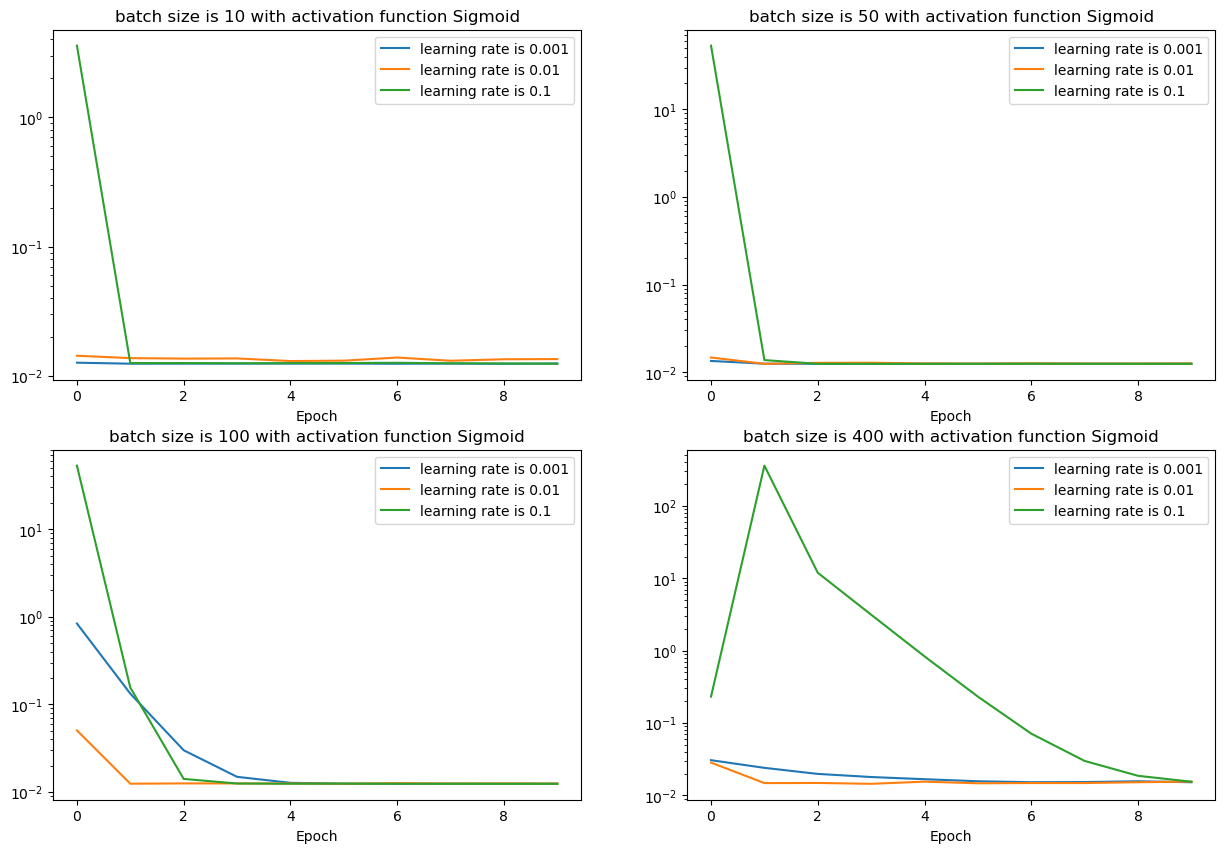

In [643]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
batch_size = [ 10, 50, 100, 400]
learning_rate=[1e-3, 1e-2, 1e-1]
start=time.time()
for i, b in enumerate(batch_size):
    for lr in learning_rate:
        # Define hyper-parameters:
        activation="Sigmoid"
        model = Model(nb_hidden_layer=4, activation=activation, nb_neuron=150)
        model.init_layers()
        model=model.to(device)
        # Choose the hyperparameters for training:
        num_epochs = 10
        batch_size = b

        # Training criterion. This one is a mean squared error (MSE) loss between the output
        # of the network and the target label
        criterion = nn.MSELoss()

        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        training_loss=train(num_epochs=num_epochs, batch_size=batch_size, criterion=criterion, optimizer=optimizer, model=model, dataset=train_set)
        test(model, X_val)
        ax[i//2,i%2].plot(training_loss, label=f"learning rate is {lr}")
        ax[i//2,i%2].set_yscale("log")
        ax[i//2,i%2].set_title(f"batch size is {batch_size} with activation function " + activation)
        ax[i//2,i%2].legend()
        ax[i//2,i%2].set_xlabel("Epoch")
    print("Time of simulation {} seconds".format(time.time() - start))

### Optimizers
The models with a learning rate of $0.01$ are the more competitive. I'll fix from now on 'ReLU' activation function and change the optimizers among {RMSprop, Adam} while varying the learning rate.

Epoch [0/10], Loss_error: 0.0051
Epoch [1/10], Loss_error: 0.0031
Epoch [2/10], Loss_error: 0.0028
Epoch [3/10], Loss_error: 0.0029
Epoch [4/10], Loss_error: 0.0032
Epoch [5/10], Loss_error: 0.0027
Epoch [6/10], Loss_error: 0.0025
Epoch [7/10], Loss_error: 0.0025
Epoch [8/10], Loss_error: 0.0032
Epoch [9/10], Loss_error: 0.0022
The loss on validation set is: 0.002239769557490945
Epoch [0/10], Loss_error: 0.0344
Epoch [1/10], Loss_error: 0.0047
Epoch [2/10], Loss_error: 0.0044
Epoch [3/10], Loss_error: 0.0030
Epoch [4/10], Loss_error: 0.0037
Epoch [5/10], Loss_error: 0.0030
Epoch [6/10], Loss_error: 0.0036
Epoch [7/10], Loss_error: 0.0034
Epoch [8/10], Loss_error: 0.0036
Epoch [9/10], Loss_error: 0.0032
The loss on validation set is: 0.0025498722679913044
Epoch [0/10], Loss_error: 16042.8498
Epoch [1/10], Loss_error: 0.0103
Epoch [2/10], Loss_error: 0.0054
Epoch [3/10], Loss_error: 0.0055
Epoch [4/10], Loss_error: 0.0057
Epoch [5/10], Loss_error: 0.0061
Epoch [6/10], Loss_error: 0.0041


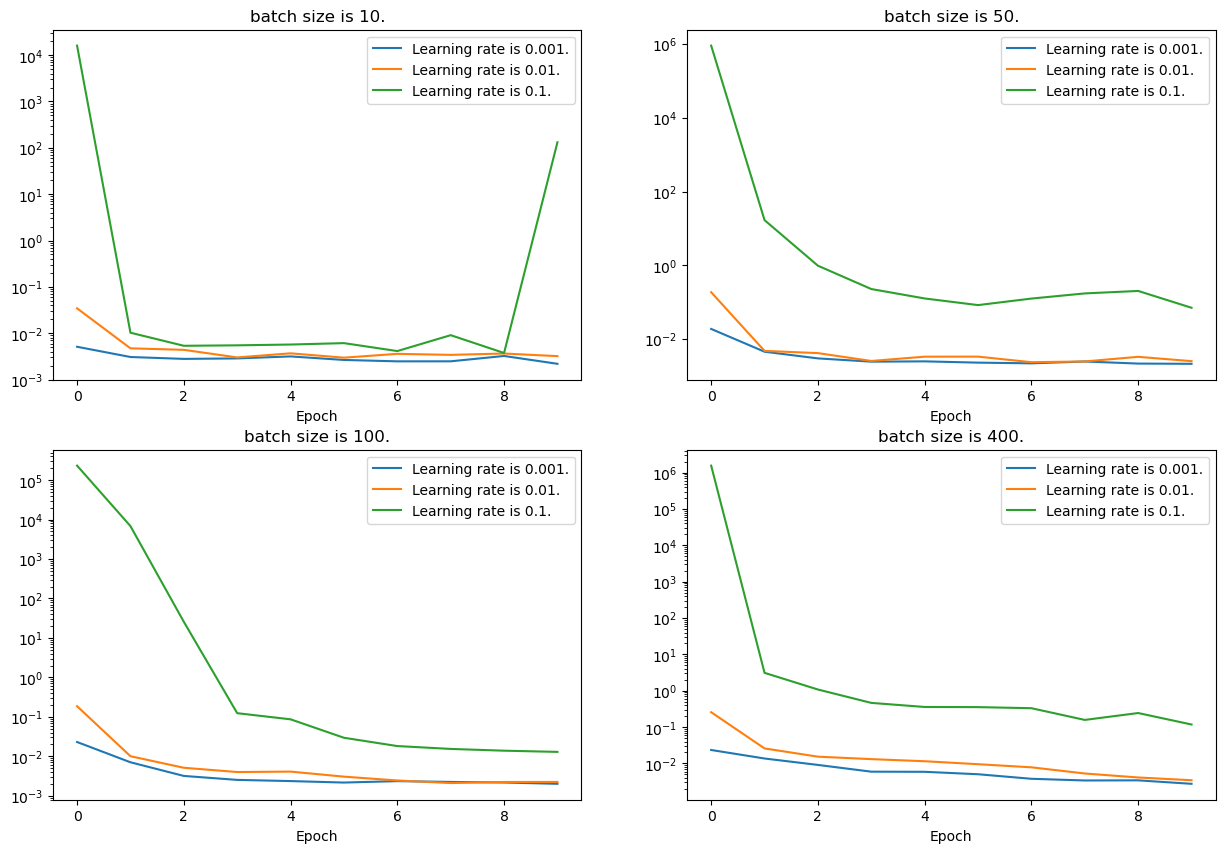

In [644]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
batch_size = [ 10, 50, 100, 400]
learning_rate=[1e-3, 1e-2, 1e-1]
start=time.time()
for i, b in enumerate(batch_size):
    for lr in learning_rate:
        # Define hyper-parameters:
        activation="ReLU"
        model = Model(nb_hidden_layer=4, activation=activation, nb_neuron=150)
        model.init_layers()
        model=model.to(device)
        # Choose the hyperparameters for training:
        num_epochs = 10
        batch_size = b

        # Training criterion. This one is a mean squared error (MSE) loss between the output
        # of the network and the target label
        criterion = nn.MSELoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        training_loss=train(num_epochs=num_epochs, batch_size=batch_size, criterion=criterion, optimizer=optimizer, model=model, dataset=train_set)
        test(model, X_val)
        ax[i//2,i%2].plot(training_loss, label=f"Learning rate is {lr}.")
        ax[i//2,i%2].set_title(f"batch size is {batch_size}.")
        ax[i//2,i%2].set_yscale('log')
        ax[i//2,i%2].legend()
        ax[i//2,i%2].set_xlabel("Epoch")
    print("Time of simulation {} seconds".format(time.time() - start))

Epoch [0/10], Loss_error: 0.0182
Epoch [1/10], Loss_error: 0.0034
Epoch [2/10], Loss_error: 0.0030
Epoch [3/10], Loss_error: 0.0031
Epoch [4/10], Loss_error: 0.0034
Epoch [5/10], Loss_error: 0.0029
Epoch [6/10], Loss_error: 0.0028
Epoch [7/10], Loss_error: 0.0028
Epoch [8/10], Loss_error: 0.0029
Epoch [9/10], Loss_error: 0.0032
The loss on validation set is: 0.003033824497833848
Epoch [0/10], Loss_error: 47596.5908
Epoch [1/10], Loss_error: 0.0080
Epoch [2/10], Loss_error: 0.0046
Epoch [3/10], Loss_error: 0.0040
Epoch [4/10], Loss_error: 0.0043
Epoch [5/10], Loss_error: 0.0059
Epoch [6/10], Loss_error: 0.0036
Epoch [7/10], Loss_error: 0.0054
Epoch [8/10], Loss_error: 0.0056
Epoch [9/10], Loss_error: 0.0057
The loss on validation set is: 0.003449629992246628
Epoch [0/10], Loss_error: 2171000213043737.7500
Epoch [1/10], Loss_error: 586657.3272
Epoch [2/10], Loss_error: 71.0735
Epoch [3/10], Loss_error: 41.3214
Epoch [4/10], Loss_error: 15.7030
Epoch [5/10], Loss_error: 2.7467
Epoch [6/10

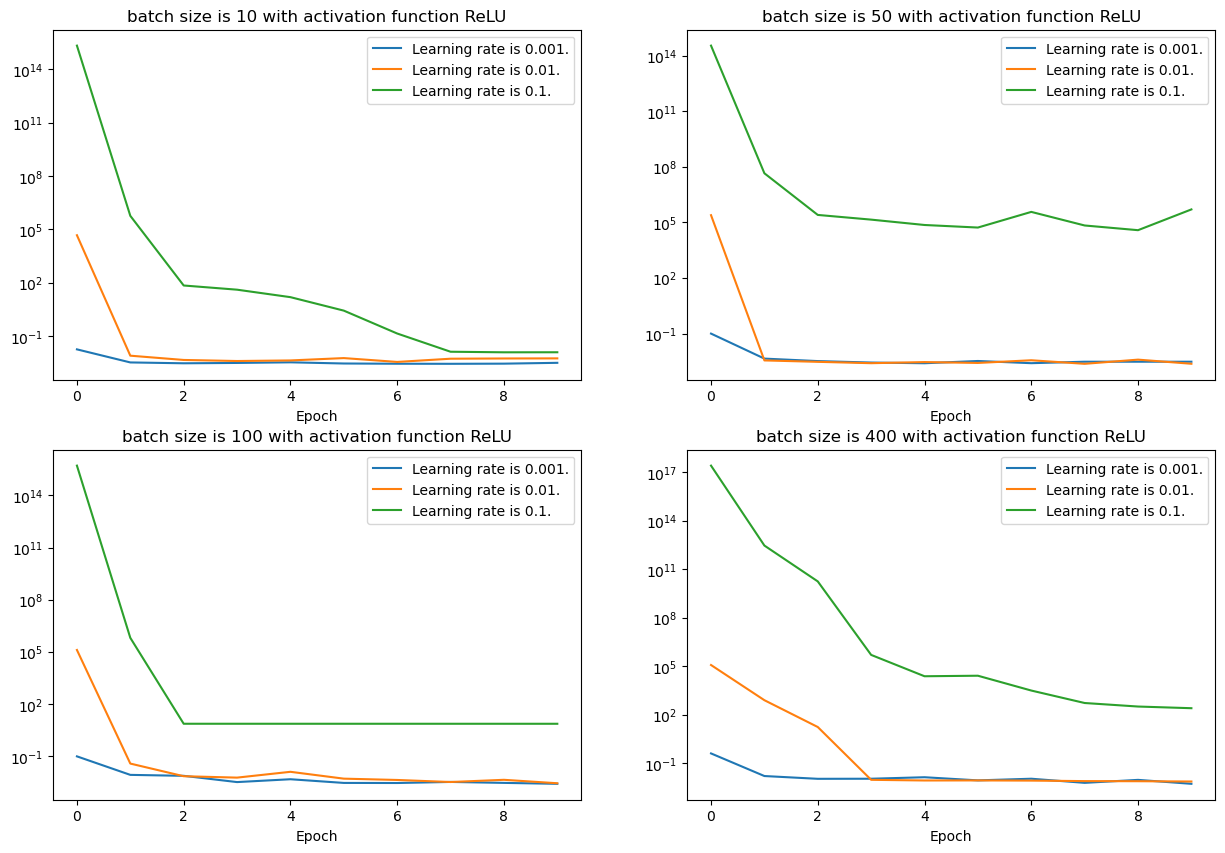

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
batch_size = [ 10, 50, 100, 400]
learning_rate=[1e-3, 1e-2, 1e-1]
start=time.time()
for i, b in enumerate(batch_size):
    for lr in learning_rate:
        # Define hyper-parameters:
        activation="ReLU"
        model = Model(nb_hidden_layer=4, activation=activation, nb_neuron=150)
        model.init_layers()
        model=model.to(device)
        # Choose the hyperparameters for training:
        num_epochs = 10
        batch_size = b

        # Training criterion. This one is a mean squared error (MSE) loss between the output
        # of the network and the target label
        criterion = nn.MSELoss()
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
        
        training_loss=train(num_epochs=num_epochs, batch_size=batch_size, criterion=criterion, optimizer=optimizer, model=model, dataset=train_set)
        test(model, X_val)
        ax[i//2,i%2].plot(training_loss, label=f"Learning rate is {lr}.")
        ax[i//2,i%2].set_title(f"batch size is {batch_size} with activation function " + activation)
        ax[i//2,i%2].set_yscale('log')
        ax[i//2,i%2].legend()
        ax[i//2,i%2].set_xlabel("Epoch")
    print("Time of simulation {} seconds".format(time.time() - start))

I keep a batch size of 100 with a SGD optimizers.

Epoch [0/10], Loss_error: 0.0631
Epoch [1/10], Loss_error: 0.0454
Epoch [2/10], Loss_error: 0.0338
Epoch [3/10], Loss_error: 0.0263
Epoch [4/10], Loss_error: 0.0215
Epoch [5/10], Loss_error: 0.0184
Epoch [6/10], Loss_error: 0.0164
Epoch [7/10], Loss_error: 0.0150
Epoch [8/10], Loss_error: 0.0141
Epoch [9/10], Loss_error: 0.0134
The loss on validation set is: 0.015101706609129906
Epoch [0/10], Loss_error: 0.0091
Epoch [1/10], Loss_error: 0.0088
Epoch [2/10], Loss_error: 0.0085
Epoch [3/10], Loss_error: 0.0083
Epoch [4/10], Loss_error: 0.0080
Epoch [5/10], Loss_error: 0.0078
Epoch [6/10], Loss_error: 0.0076
Epoch [7/10], Loss_error: 0.0074
Epoch [8/10], Loss_error: 0.0072
Epoch [9/10], Loss_error: 0.0070
The loss on validation set is: 0.00839385949075222
Epoch [0/10], Loss_error: 0.0497
Epoch [1/10], Loss_error: 0.0095
Epoch [2/10], Loss_error: 0.0077
Epoch [3/10], Loss_error: 0.0073
Epoch [4/10], Loss_error: 0.0068
Epoch [5/10], Loss_error: 0.0058
Epoch [6/10], Loss_error: 0.0061
Epoch 

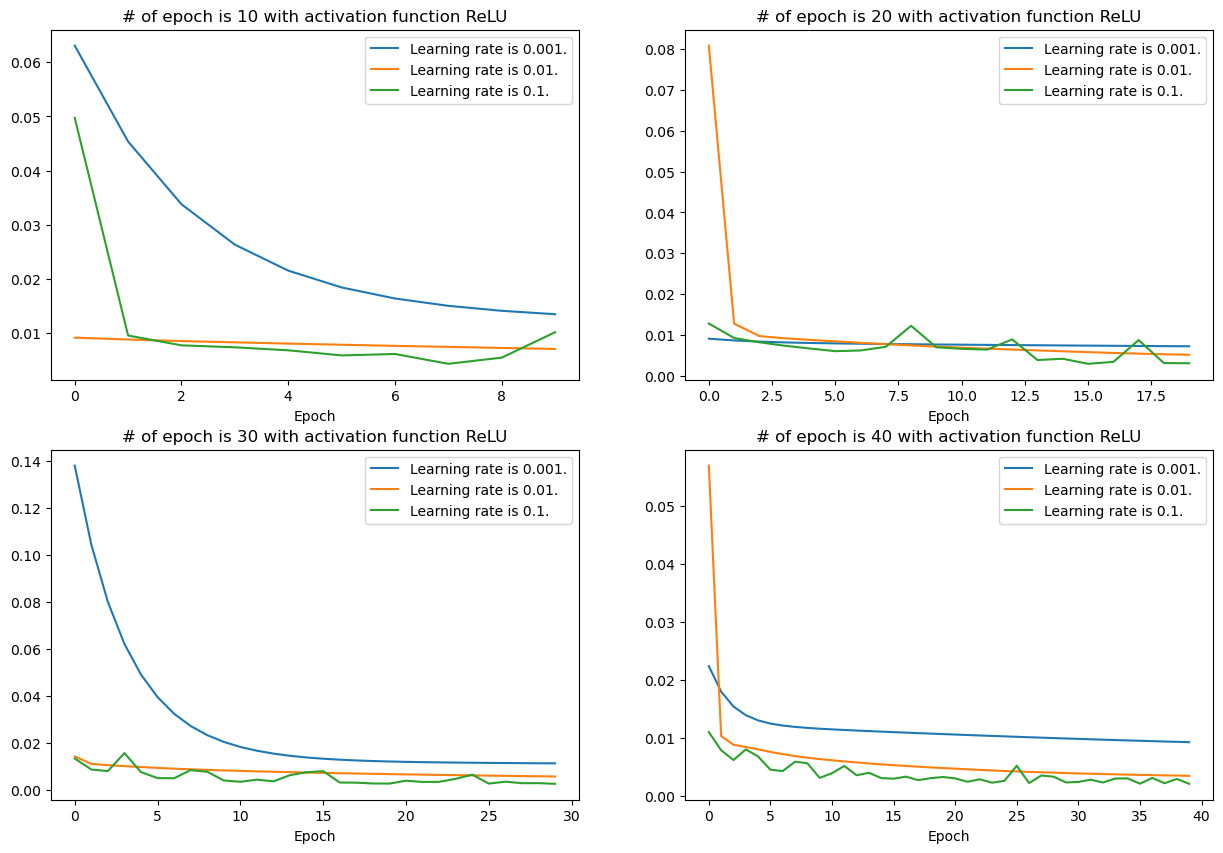

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
num_epochs = [ 10, 20, 30, 40]
learning_rate=[1e-3, 1e-2, 1e-1]
start=time.time()
for i, epoch in enumerate(num_epochs):
    for lr in learning_rate:
        # Define hyper-parameters:
        activation="ReLU"
        model = Model(nb_hidden_layer=4, activation=activation, nb_neuron=150)
        model.init_layers()
        model=model.to(device)
        # Choose the hyperparameters for training:
        num_epochs = epoch
        batch_size = 100

        # Training criterion. This one is a mean squared error (MSE) loss between the output
        # of the network and the target label
        criterion = nn.MSELoss()

        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        training_loss = train(num_epochs=num_epochs, batch_size=batch_size, criterion=criterion, optimizer=optimizer, model=model, dataset=train_set)
        test(model, X_val)
        ax[i//2,i%2].plot(training_loss, label=f"Learning rate is {lr}.")
        ax[i//2,i%2].set_title(f"# of epoch is {epoch} with activation function " + activation)
        ax[i//2,i%2].legend()
        ax[i//2,i%2].set_xlabel("Epoch")
    print("Time of simulation {} seconds".format(time.time() - start))

### Exercise 3: Impact of the loss function
As mensioned before in the first problem (binary classification), one can minimize the negative of log-likelihood of the probability for all samples $x$: $$ \sum_{(x,y) \,\in\, \text{Dataset}} - \log p(y | x) $$ If we define $p(y_i | x_i) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(y_i - f(x_i))^2}{2}}$, then the loss function becomes the mean squared error. 

There is another loss function worth to try: the Gaussian likelihood loss function. 
Rather than predicting a single value $y$ given $x$, we predict a probability distribution over possible answers, which helps dealing with ambiguous cases and expressing uncertainty. To do this, for each possible input $x$, the network will output the parameters of the distribution modeling $p(y|x)$. For instance in our case, we choose to model output distributions with Gaussian distributions $\mathcal{N}(\mu, \sigma)$, which are parameterized by their mean $\mu$ and their standard deviation $\sigma$. Therefore for each input $x$, we have to output two quantities: $\mu(x)$ and $\sigma(x)$. The probability becomes: $$p(y_i | x_i) = \frac{1}{\sqrt{2\pi \sigma(x_i)^2}}e^{-\frac{(y_i - \mu(x_i))^2}{2\sigma(x_i)^2}}$$ Then the loss function becomes: $$L =\sum\limits_{i=1}^{N}  \frac{1}{2} \log ( 2\pi\sigma_i^{2} ) + \frac{1}{2\sigma_i^{2}}  (y_{i} - \mu_i)^{2}$$ If we set $\sigma=1$, we obtain MSE the loss function. 

* Try to replace the loss function with this one, and compare the differences between the two losses.
 
* **Hints**: 
    * You need two outputs of your network, one represents the $\mu(x_i)$, another for $\log( \sigma(x_i)^2 )$ (better for optimization) 
    * Try deeper models, or you will not predict the variance $\sigma$ well. 

Note that the training does not work at all when using SGD optimizer.

In [595]:
# Construct a model with one layer
class Model_gauss(nn.Module):
    
    def __init__(self, nb_hidden_layer = 2, activation = "ReLU", nb_neuron = 3):
        super(Model_gauss, self).__init__()
        self.l1 = nn.Linear(4, nb_neuron)
        if activation == "ReLU":
            self.activation = nn.ReLU()
        elif activation == "Tanh":
            self.activation = nn.Tanh()
        elif activation == "Sigmoid":
            self.activation = nn.Sigmoid()
        else:
            raise ValueError(f"No activation function is available for {activation}.")

        list_layer = [self.l1, self.activation]
        for i in range(nb_hidden_layer):
            list_layer += [nn.Linear(nb_neuron, nb_neuron, bias=True)]
            list_layer += [self.activation]
        list_layer += [nn.Linear(nb_neuron, 2, bias=True)]
        self.layer=nn.Sequential(*list_layer)

    def init_layers(self):
        for param in self.parameters():
            nn.init.normal_(param, mean=0, std=.1)
    def forward(self, x):
        return self.layer(x)

In [615]:
def train_gauss(num_epochs, batch_size, optimizer, model, dataset):
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    training_loss=[]
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X, y) in dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device).squeeze()
            output = model(X)
            mean_y, log_var2 = output[:,0], output[:,1]
            loss = torch.sum((mean_y - y)**2/(2*torch.exp(log_var2))) + 1/2*torch.sum(log_var2)
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)
        training_loss += [epoch_average_loss]
        if ((epoch)%1 == 0):
                print('Epoch [{}/{}], Loss_error: {:.4f}'
                      .format(epoch, num_epochs,  epoch_average_loss))
    return training_loss

In [662]:
def test_gauss(model, X_val):
    model.eval()
    criterion=nn.MSELoss()
    test_loss = []
    with torch.no_grad():
        Output = model(torch.tensor(X_val).float().to(device))
        mean_y, log_var2 = Output[:,0], Output[:,1]
        y_pred = torch.normal(mean_y, torch.sqrt(torch.exp(log_var2))).to(device)
    error = criterion(y_pred, torch.tensor(np.array(y_val)).float().to(device)).item()
    return error

Epoch [0/10], Loss_error: -6.0917
Epoch [1/10], Loss_error: -7.5261
Epoch [2/10], Loss_error: -8.9042
Epoch [3/10], Loss_error: -10.2650
Epoch [4/10], Loss_error: -11.6500
Epoch [5/10], Loss_error: -13.1839
Epoch [6/10], Loss_error: -15.2780
Epoch [7/10], Loss_error: -19.2661
Epoch [8/10], Loss_error: -29.1988
Epoch [9/10], Loss_error: -63.7027
Epoch [0/10], Loss_error: -9.5391
Epoch [1/10], Loss_error: -75.0909
Epoch [2/10], Loss_error: -137.1796
Epoch [3/10], Loss_error: -152.7572
Epoch [4/10], Loss_error: -160.4665
Epoch [5/10], Loss_error: -166.7424
Epoch [6/10], Loss_error: -164.7507
Epoch [7/10], Loss_error: -166.3301
Epoch [8/10], Loss_error: -169.2016
Epoch [9/10], Loss_error: -167.6482
Epoch [0/10], Loss_error: -67.9398
Epoch [1/10], Loss_error: -141.1176
Epoch [2/10], Loss_error: -153.7791
Epoch [3/10], Loss_error: -161.3830
Epoch [4/10], Loss_error: -163.1181
Epoch [5/10], Loss_error: -164.2481
Epoch [6/10], Loss_error: -166.5545
Epoch [7/10], Loss_error: -168.4564
Epoch [8/

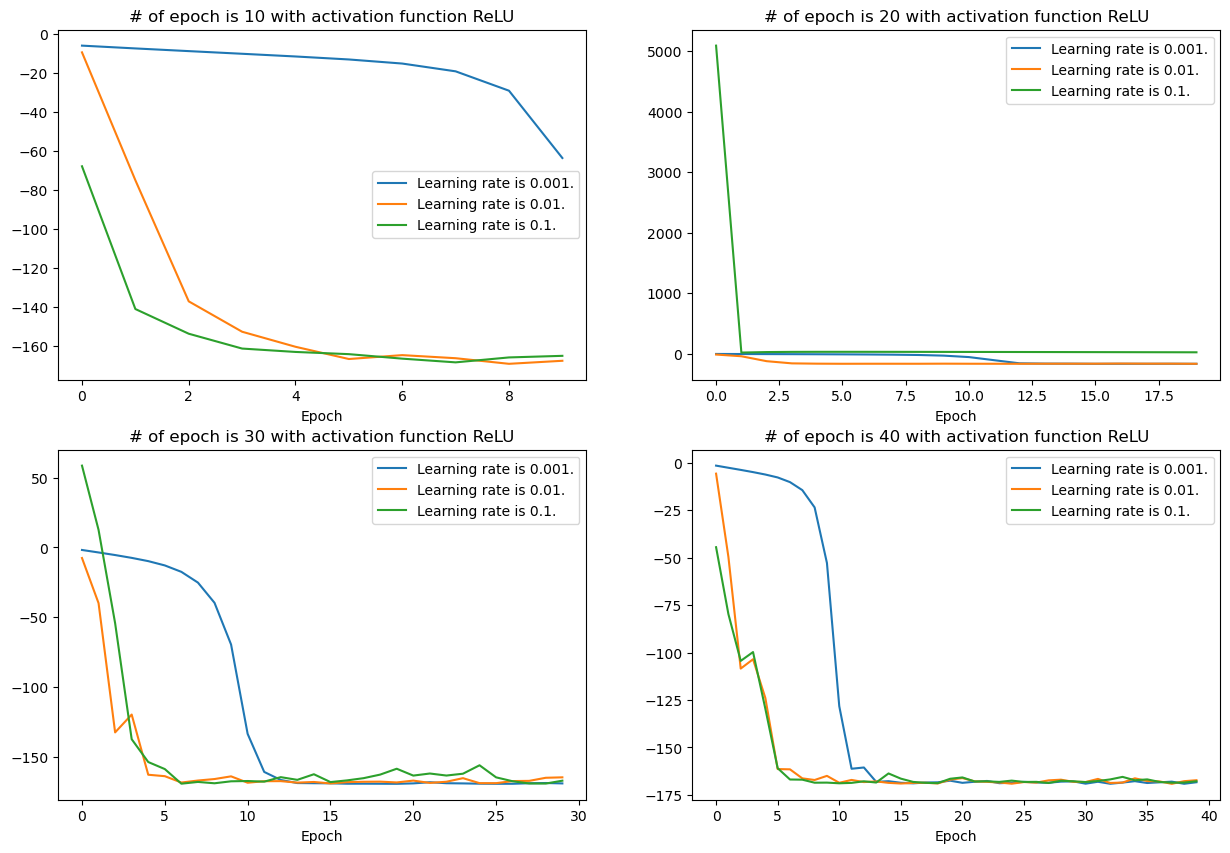

In [661]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
num_epochs = [ 10, 20, 30, 40]
learning_rate=[1e-3, 1e-2, 1e-1]
start=time.time()
for i, epoch in enumerate(num_epochs):
    for lr in learning_rate:
        # Define hyper-parameters:
        activation="ReLU"
        model = Model_gauss(nb_hidden_layer=30, activation=activation, nb_neuron=15)
        model.init_layers()
        model=model.to(device)
        # Choose the hyperparameters for training:
        num_epochs = epoch
        batch_size = 100

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        training_loss = train_gauss(num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer, model=model, dataset=train_set)
        test_gauss(model, X_val)
        ax[i//2,i%2].plot(training_loss, label=f"Learning rate is {lr}.")
        ax[i//2,i%2].set_title(f"# of epoch is {epoch} with activation function " + activation)
        ax[i//2,i%2].legend()
        ax[i//2,i%2].set_xlabel("Epoch")
    print("Time of simulation {} seconds".format(time.time() - start))

Epoch [0/10], Loss_error: 2.0197
Epoch [1/10], Loss_error: -1.2541
Epoch [2/10], Loss_error: -5.1957
Epoch [3/10], Loss_error: -11.5585
Epoch [4/10], Loss_error: -24.2620
Epoch [5/10], Loss_error: -44.1603
Epoch [6/10], Loss_error: -65.3111
Epoch [7/10], Loss_error: -84.2482
Epoch [8/10], Loss_error: -100.2889
Epoch [9/10], Loss_error: -114.0542
Epoch [0/10], Loss_error: -19.7944
Epoch [1/10], Loss_error: -88.1593
Epoch [2/10], Loss_error: -150.3338
Epoch [3/10], Loss_error: -161.3959
Epoch [4/10], Loss_error: -168.3136
Epoch [5/10], Loss_error: -165.5414
Epoch [6/10], Loss_error: -168.1649
Epoch [7/10], Loss_error: -166.3999
Epoch [8/10], Loss_error: -167.1217
Epoch [9/10], Loss_error: -168.0226
Epoch [0/10], Loss_error: 24.4491
Epoch [1/10], Loss_error: 3.4863
Epoch [2/10], Loss_error: 96.1548
Epoch [3/10], Loss_error: 127.4235
Epoch [4/10], Loss_error: 90.1866
Epoch [5/10], Loss_error: -57.5517
Epoch [6/10], Loss_error: -100.2923
Epoch [7/10], Loss_error: -112.0865
Epoch [8/10], Los

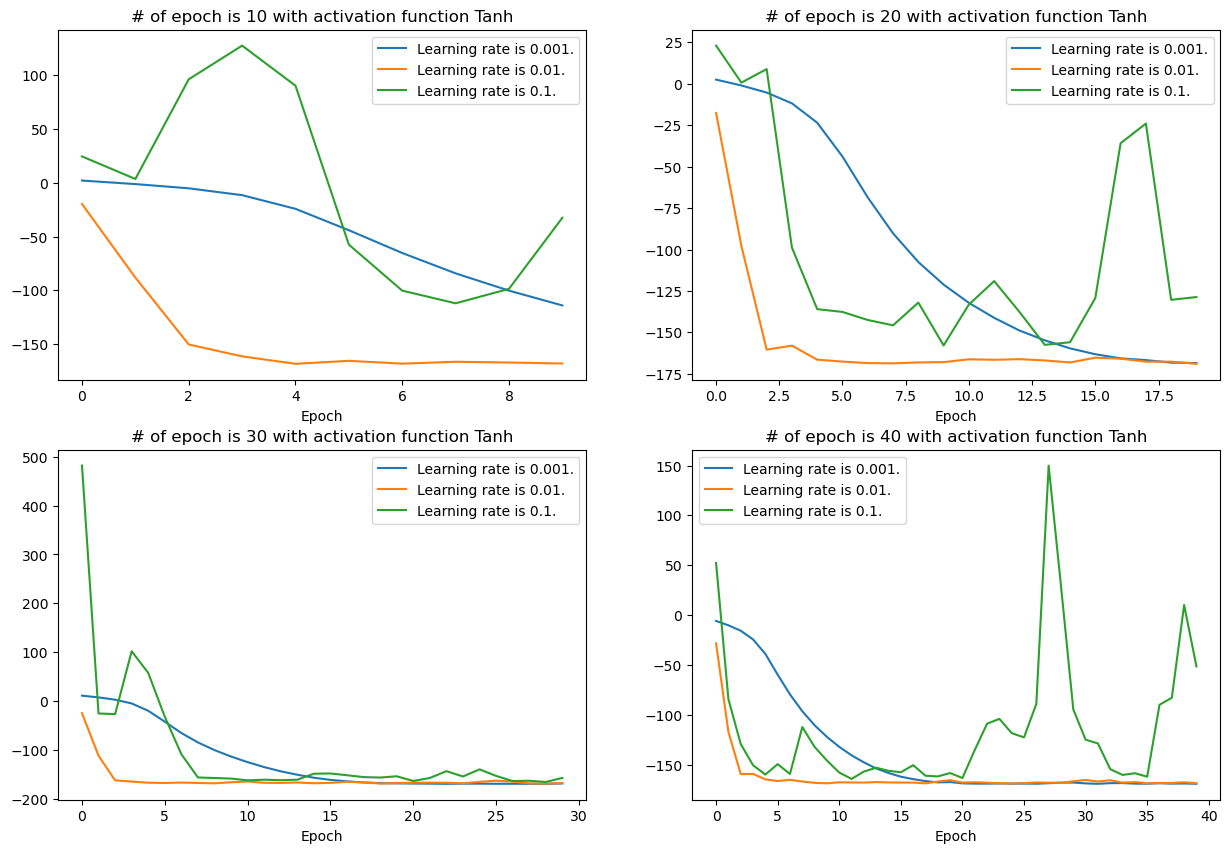

In [659]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
num_epochs = [ 10, 20, 30, 40]
learning_rate=[1e-3, 1e-2, 1e-1]
start=time.time()
for i, epoch in enumerate(num_epochs):
    for lr in learning_rate:
        # Define hyper-parameters:
        activation="Tanh"
        model = Model_gauss(nb_hidden_layer=30, activation=activation, nb_neuron=15)
        model.init_layers()
        model=model.to(device)
        # Choose the hyperparameters for training:
        num_epochs = epoch
        batch_size = 100

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        training_loss = train_gauss(num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer, model=model, dataset=train_set)
        test_gauss(model, X_val)
        ax[i//2,i%2].plot(training_loss, label=f"Learning rate is {lr}.")
        ax[i//2,i%2].set_title(f"# of epoch is {epoch} with activation function " + activation)
        ax[i//2,i%2].legend()
        ax[i//2,i%2].set_xlabel("Epoch")
    print("Time of simulation {} seconds".format(time.time() - start))

Epoch [0/10], Loss_error: -4.4384
Epoch [1/10], Loss_error: -14.6529
Epoch [2/10], Loss_error: -23.9696
Epoch [3/10], Loss_error: -32.4450
Epoch [4/10], Loss_error: -40.3204
Epoch [5/10], Loss_error: -47.8904
Epoch [6/10], Loss_error: -55.5689
Epoch [7/10], Loss_error: -63.7397
Epoch [8/10], Loss_error: -72.5533
Epoch [9/10], Loss_error: -81.8691
Epoch [0/10], Loss_error: -12.2009
Epoch [1/10], Loss_error: -73.2618
Epoch [2/10], Loss_error: -136.6249
Epoch [3/10], Loss_error: -165.4898
Epoch [4/10], Loss_error: -165.9182
Epoch [5/10], Loss_error: -167.3718
Epoch [6/10], Loss_error: -166.4509
Epoch [7/10], Loss_error: -168.3537
Epoch [8/10], Loss_error: -168.5458
Epoch [9/10], Loss_error: -168.7535
Epoch [0/10], Loss_error: -62.8817
Epoch [1/10], Loss_error: -114.2781
Epoch [2/10], Loss_error: -158.9728
Epoch [3/10], Loss_error: -163.9517
Epoch [4/10], Loss_error: -166.1522
Epoch [5/10], Loss_error: -166.0668
Epoch [6/10], Loss_error: -165.0424
Epoch [7/10], Loss_error: -168.4701
Epoch 

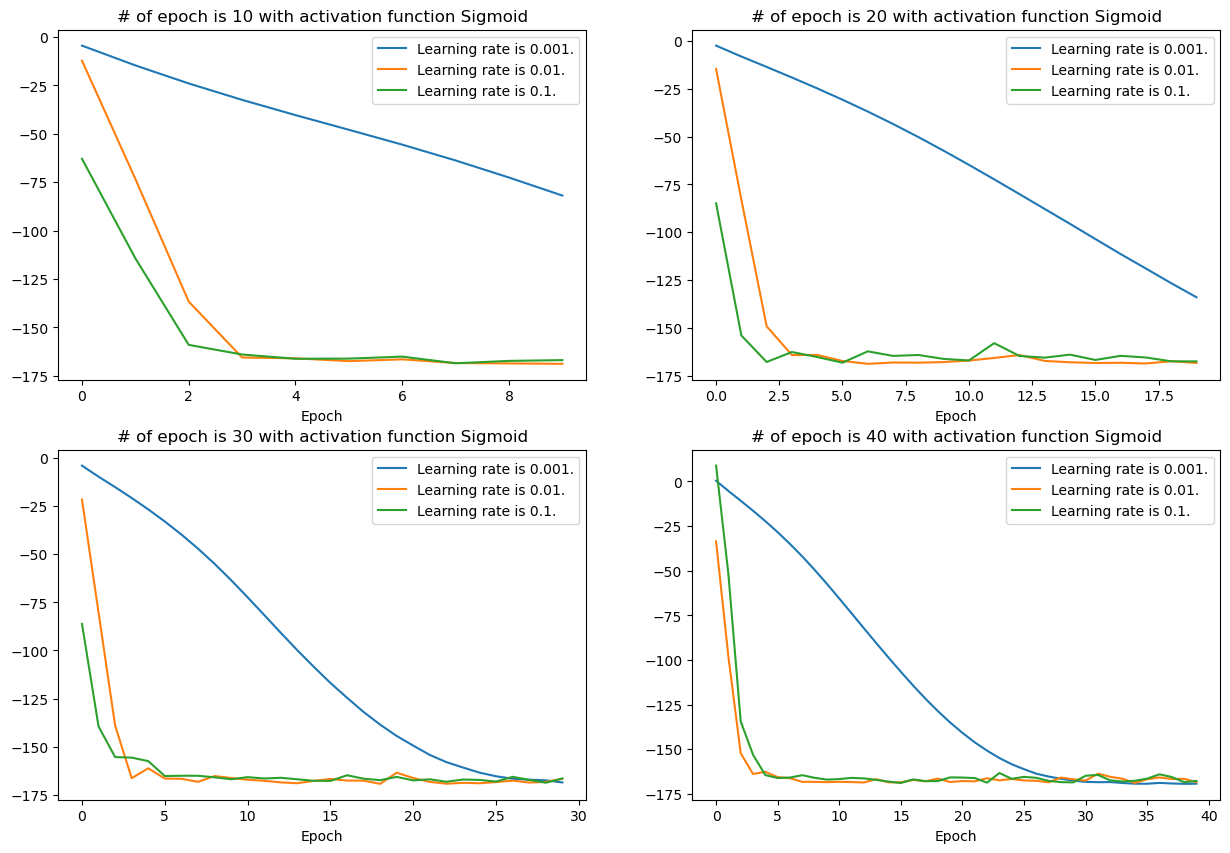

In [660]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
num_epochs = [ 10, 20, 30, 40]
learning_rate=[1e-3, 1e-2, 1e-1]
start=time.time()
for i, epoch in enumerate(num_epochs):
    for lr in learning_rate:
        # Define hyper-parameters:
        activation="Sigmoid"
        model = Model_gauss(nb_hidden_layer=30, activation=activation, nb_neuron=15)
        model.init_layers()
        model=model.to(device)
        # Choose the hyperparameters for training:
        num_epochs = epoch
        batch_size = 100

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        training_loss = train_gauss(num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer, model=model, dataset=train_set)
        test_gauss(model, X_val)
        ax[i//2,i%2].plot(training_loss, label=f"Learning rate is {lr}.")
        ax[i//2,i%2].set_title(f"# of epoch is {epoch} with activation function " + activation)
        ax[i//2,i%2].legend()
        ax[i//2,i%2].set_xlabel("Epoch")
    print("Time of simulation {} seconds".format(time.time() - start))

### Exercice 4: Prediction on test set

* Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.
* When using the Gaussian likelihood function, the confidence of the network in its prediction is reflected in the variance it outputs. It can be interesting to check how this uncertainty varies with the data. For example, the uncertainty will decrease when the feature `OverallQual` increases. Plot the variance $\sigma(x)$ w.r.t one of the three features, on test set, and describe what you observe.